In [ ]:
# 다중 분류, 숫자 이미지의 짝수/홀수 판별, MLP, CPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# %autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os 
import random
import sys
import time
from time import localtime, strftime

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sb
import cv2

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/mnist' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ----------------------------------------------------------------
# OS
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
# ----------------------------------------------------------------

### 배치 정규화
- 활성화 함수로 값이 전달되기전에 정규화(표준화)를 진행하여 분산을 동일하게 변경함, 큰 정수가 작아짐으로 이상치의 영향 감소

In [8]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

width=28
height=28

(x_train_all, y_train_all), (x_test, y_test)  = mnist.load_data()

# 정규화(Normalization), 60000행  X 784열
x_train_all = x_train_all.reshape(x_train_all.shape[0], width * height).astype('float32') / 255 
x_test = x_test.reshape(x_test.shape[0], width * height).astype('float32') / 255 # 10000 X 784

y_train_all = to_categorical(y_train_all, 10)  # One-Hot encoding
y_test = to_categorical(y_test, 10)


# 80%: 훈련, 20%: 검증
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.2,
                                                  random_state=SEED)

# Dense + ReLU
model_a = Sequential(
[
    Flatten(input_shape=[width*height]), # input_shape=(29, 28) X
    Dense(30, activation='relu'),
    Dense(20, activation='relu'),
    Dense(10, activation='softmax'),
    
])
model_a.summary()


# Dense + BatchNorm + ReLU
model_b = Sequential(
[
    Flatten(input_shape=[width*height]), # 
    Dense(30),
    BatchNormalization(), # 데이터를 scale 조절
    Activation('relu'),
    
    Dense(20),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(10, activation='softmax'),
    
])
model_b.summary()

model_a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 30)                23550     
                                                                 
 dense_9 (Dense)             (None, 20)                620       
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)        

In [9]:
hist_a = model_a.fit(x_train, y_train, validation_data=(x_val, y_val),
                   epochs=5, batch_size=50, callbacks=[es])

hist_b = model_b.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=5, batch_size=50, callbacks=[es])

Epoch 1/5
960/960 [==============================] - 7s 6ms/step - loss: 0.4414 - accuracy: 0.8734 - val_loss: 0.2429 - val_accuracy: 0.9323
Epoch 2/5
960/960 [==============================] - 6s 6ms/step - loss: 0.2096 - accuracy: 0.9391 - val_loss: 0.1971 - val_accuracy: 0.9430
Epoch 3/5
960/960 [==============================] - 6s 6ms/step - loss: 0.1694 - accuracy: 0.9495 - val_loss: 0.1648 - val_accuracy: 0.9528
Epoch 4/5
960/960 [==============================] - 6s 6ms/step - loss: 0.1443 - accuracy: 0.9570 - val_loss: 0.1611 - val_accuracy: 0.9546
Epoch 5/5
960/960 [==============================] - 6s 6ms/step - loss: 0.1281 - accuracy: 0.9612 - val_loss: 0.1487 - val_accuracy: 0.9575
Epoch 1/5
960/960 [==============================] - 10s 9ms/step - loss: 0.5048 - accuracy: 0.8703 - val_loss: 0.2101 - val_accuracy: 0.9418
Epoch 2/5
960/960 [==============================] - 9s 9ms/step - loss: 0.1985 - accuracy: 0.9417 - val_loss: 0.1628 - val_accuracy: 0.9516
Epoch 3/5
96

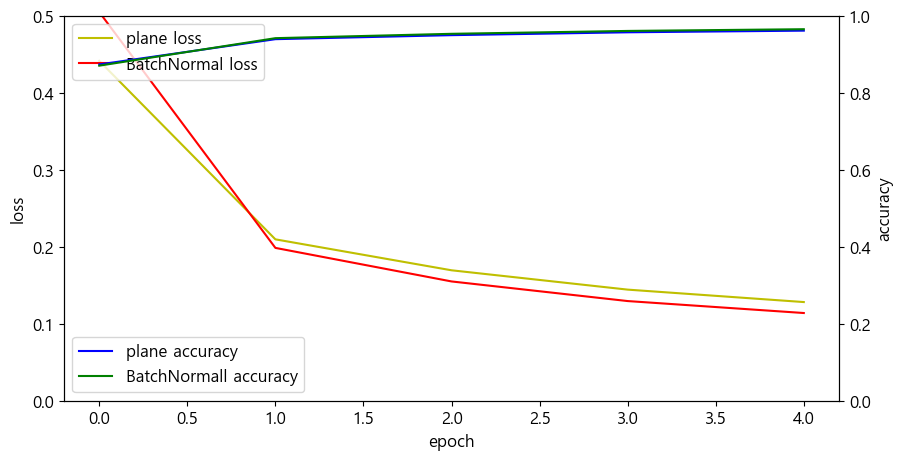

In [10]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist_a.history['loss'], 'y', label='plane loss')
loss_ax.plot(hist_b.history['loss'], 'r', label='BatchNormal loss')
loss_ax.set_ylim([0.0, 0.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist_a.history['accuracy'], 'b', label='plane accuracy')
acc_ax.plot(hist_b.history['accuracy'], 'g', label='BatchNormall accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch' )  # 학습 횟수
loss_ax.set_ylabel('loss')    # 왼쪽 y 축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y 축 레이블,정확도

loss_ax.legend(loc='upper left') # 왼쪽 y 축 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 오른쪽 y 축 정확도 레이블 위치

plt.show()

In [ ]:
test_loss, test_acc = model_a.evaluate(x_test, y_test, batch_size=50, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')